In [1]:
'''This block links the notebook to other folders.'''

import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- 2. Define Absolute Path for figs folder ---
figs_dir = os.path.join(project_root, 'figs')
data_dir = os.path.join(project_root, 'generated_data')

# Create the directory if it doesn't exist (good practice!)
os.makedirs(figs_dir, exist_ok=True) 

In [6]:
from src import Halos, SimSlab, BiasModel, ThetaModel, ModelComparison, SimCube
from src import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from mpmath import gammainc
from mpmath import erf
import plothist

In [7]:
def gammainc_vec(a, x):
    result = []
    for i in range(x.size):
        result.append(float(gammainc(a[i], x[i])))
        
    return np.array(result)

def erf_vec(x):
    result = []
    for i in range(x.size):
        result.append(float(erf(x[i])))
        
    return np.array(result)

In [8]:
dens_512 = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/deltam.fits")
dens_512 = pd.DataFrame(dens_512[1].data)
ix_matter = dens_512["ix"]
iy_matter = dens_512["iy"]
iz_matter = dens_512["iz"]
dens = dens_512["dens"]
delta_m_grid = SimSlab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=512)

In [9]:
dens_512.columns

Index(['ix', 'iy', 'iz', 'dens'], dtype='object')

In [10]:
L      = 1000.

# Define the width of the slabs

slab_width = 125.

In [11]:
def rebin(a, N):
    sh = (N,a.shape[0]//N,
          N,a.shape[1]//N,
          N,a.shape[2]//N)

    b = a.reshape(sh)        
    return a.reshape(sh).mean(-1).mean(-2).mean(-3)

dens_256 = rebin(delta_m_grid, 256)
halo_df_filename = "/Users/elyasfarah/Documents/Galaxy Bias/halos.fits"

field_3d = SimCube(dens_256, L=L)
halos_256    = Halos(halo_df_filename, L, 256, MASS_CUTOFF_HIGH=10**16, MASS_CUTOFF_LOW=1e12)

Computing tidal fields...


In [12]:
# Extract eight 2d density slabs from the 3d density

delta_2d_list = field_3d.get_all_delta_slabs(slab_width)

In [13]:
del dens_256, delta_m_grid, dens_512

In [14]:
delta_2d_arr = np.array(delta_2d_list)
ncells = 8*4096
delta_m_vec = np.sort(delta_2d_arr.flatten())
delta_m_2D_bins = delta_m_vec.reshape(-1,ncells)

delta_m_bin_edges1 = np.zeros(delta_m_2D_bins.shape[0] + 1)
delta_m_bin_edges1[0] = np.min(delta_m_2D_bins, axis=1)[0]
delta_m_bin_edges1[-1] = np.max(delta_m_2D_bins, axis=1)[-1]
delta_m_bin_edges1[1:-1] = (np.max(delta_m_2D_bins, axis=1)[:-1] + np.min(delta_m_2D_bins, axis=1)[1:])/2

In [15]:
# splitting the last bin into more bins
ncells2 = 4*2048
delta_m_last_bin = delta_m_2D_bins[-1].reshape(-1, ncells2)
delta_m_bin_edges2 = np.zeros(delta_m_last_bin.shape[0] + 1)
delta_m_bin_edges2[0] = np.min(delta_m_last_bin, axis=1)[0]
delta_m_bin_edges2[-1] = np.max(delta_m_last_bin, axis=1)[-1]
delta_m_bin_edges2[1:-1] = (np.max(delta_m_last_bin, axis=1)[:-1] + np.min(delta_m_last_bin, axis=1)[1:])/2

In [16]:
delta_bins = np.concatenate([delta_m_bin_edges1[:-2], delta_m_bin_edges2])

In [17]:
mass_bins = np.logspace(12, 16,50)
mass_bin_centre = np.sqrt(mass_bins[1:] * mass_bins[:-1])

In [18]:
slab_id = (halos_256.z_halo // slab_width).astype(int)


In [19]:
nM_list = []

delta_mean_list = []
halos = halos_256
for i in range(len(delta_bins) - 1):
    delta_halo = delta_2d_arr[slab_id,halos.ix_halo, halos.iy_halo] #TAKING THE VOXELS THAT HAVE HALOS
    select_halo_delta = (delta_halo > delta_bins[i]) & (delta_halo < delta_bins[i+1]) # TAKING THE VOXELS IN A PARTICULAR DELTA_M BIN
    select_halo_mass  = halos.halo_mass[select_halo_delta] # MASKING OUT THE HALOS WHICH DO NOT EXIST IN THE CORRESPONDING DELTA_M BIN
    select_delta_bin = (delta_2d_arr > delta_bins[i]) & (delta_2d_arr < delta_bins[i+1]) # TAKING THE VOXELS IN A PARTICULAR DELTA_M BIN # MASKING OUT VOXELS OUTSIDE THE CHOSEN DELTA_M BIN
    delta_mean = delta_2d_arr[select_delta_bin].mean() # MASKING OUT VOXELS OUTSIDE THE CHOSEN DELTA_M BIN # THE MEAN DELTA_M OF THE SELECTED VOXELS
    delta_mean_list.append(delta_mean)
    
    N_pix = select_delta_bin.sum() # FIND THE NUMBER OF PIXELS IN THAT PARTICULr mass bin
    nV = select_halo_delta.sum() / N_pix # FIND THE AVERAGE NUMBER OF HALOS IN A VOXEL 
    
    pM, _ = np.histogram(select_halo_mass, mass_bins, density=True) # FIND THE WEIGHTED DISTRIBUTION OF HALO MASS IN EACH BIN
    nM_list.append(pM * nV) # FIND THE FRACTION OF HALOS IN EACH MASS BIN

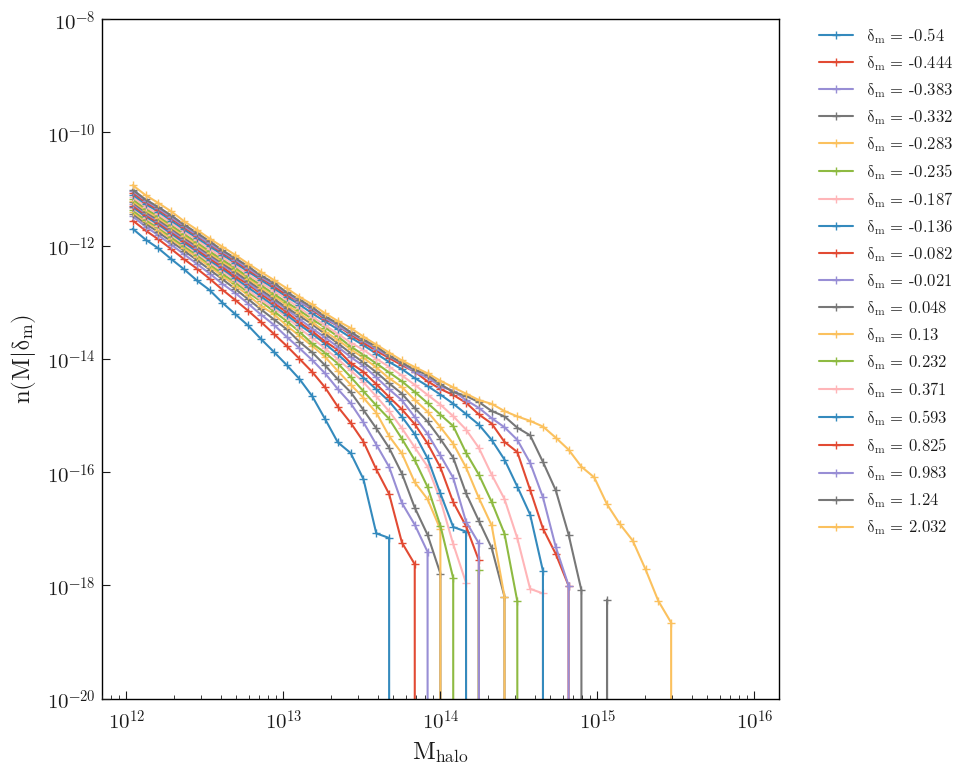

In [20]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.ylim(1e-20, 1e-8)
for i in range(len(nM_list)):
   
    plt.plot(mass_bin_centre, nM_list[i],  marker = '+', label = rf'$\delta_m$ = {np.round(delta_mean_list[i], 3)}')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$M_{halo}$")
plt.ylabel(r"$n(M|\delta_{m})$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

fig.savefig(f'{figs_dir}/n_M_delta.png', dpi = 300)

In [30]:
class Bounds:
    '''A class that helps controlaing the bouds of a cube in parameter space. It slides the parameter space
    according to '''
    def __init__(self, ns, alpha, M0, beta):
        self.log10_ns = ns
        self.alpha = alpha
        self.log10_M0 = M0
        self.beta = beta
        
    def get_bounds(self):
        return [self.log10_ns, self.alpha, self.log10_M0,  self.beta]
    
    def change_bounds_to_params(self, parameters):
        another_round = False
        for i in range(parameters.size):
            param_name = list(vars(self).keys())[i]
            
            param_bound =  vars(self)[param_name]
            
            if parameters[i] <= param_bound[0]:
                
                if param_name == "beta":
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)
                elif param_name == "alpha":
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)     
                else:
                    new_bounds = (param_bound[0] - 1.0, param_bound[1] - 1.0)
                setattr(self, param_name, new_bounds)
                another_round = True
            elif parameters[i] >= param_bound[1]:
                if param_name == 'beta':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)
                elif param_name == 'alpha':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)    
                else:
                    new_bounds = (param_bound[0] + 1.0, param_bound[1] + 1.0)
                setattr(self, param_name, new_bounds)
                another_round = True
        return another_round
    
    def get_lower_bounds(self):
        bounds = self.get_bounds()
        lower_bounds = np.min(bounds, axis = 1) + 0.05
        return  lower_bounds

In [50]:
bounds = Bounds((-17.3, -16.3),  (-1.9, -1.6),  (15., 16.),  (2.8, 3.2))

In [51]:
parameters = []
parameters_errors = []

In [52]:
from scipy.optimize import differential_evolution
for i in range(len(delta_mean_list)):
    round = 1
    index = len(delta_mean_list) - i -1
    while True:
        print('round', round, 'for bin', index)
        objective_function = lambda params: minus_Likelihood(delta_2d_arr, halos_256, delta_bins[index], delta_bins[index + 1], 12, 16, 125, *params)
        print(bounds.get_bounds(), bounds.get_lower_bounds())
        res = differential_evolution(objective_function, bounds = bounds.get_bounds(), x0 = bounds.get_lower_bounds() , seed = 42, maxiter=2500)
        change_bounds = bounds.change_bounds_to_params(res.x)
        if change_bounds:
            round = round + 1
            
        else:
            parameters.append(res.x)
            parameters_errors.append(res.population)
            print('bin', index, 'is completed within', round, 'rounds')
            print('===========')
            break

round 1 for bin 18
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (2.8, 3.2)] [-17.25  -1.85  15.05   2.85]
round 2 for bin 18
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (3.0, 3.4000000000000004)] [-17.25  -1.85  15.05   3.05]
bin 18 is completed within 2 rounds
round 1 for bin 17
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (3.0, 3.4000000000000004)] [-17.25  -1.85  15.05   3.05]
round 2 for bin 17
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.0, 3.4000000000000004)] [-16.25  -1.85  14.05   3.05]


/Users/elyasfarah/Documents/Galaxy Bias/Empirical_Halo_bias/src/schechter_func.py:72: RuntimeWarning: divide by zero encountered in log
  term1 = np.log(schechter_function(halo_mass_masked, log10_ns, alpha, log10_M0, beta))


round 3 for bin 17
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-16.25  -1.85  14.05   3.25]
bin 17 is completed within 3 rounds
round 1 for bin 16
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-16.25  -1.85  14.05   3.25]
bin 16 is completed within 1 rounds
round 1 for bin 15
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-16.25  -1.85  14.05   3.25]
bin 15 is completed within 1 rounds
round 1 for bin 14
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-16.25  -1.85  14.05   3.25]
bin 14 is completed within 1 rounds
round 1 for bin 13
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-16.25  -1.85  14.05   3.25]
bin 13 is completed within 1 rounds
round 1 for bin 12
[(-16.3, -15.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-16.25  -1.85  14.05   3.25]
round 2 for bin 12
[(-15.3, -14.3), (-1.9, -1.6), (14.0, 15.0), (3.2, 3.6000000000000005)] [-1

In [113]:
color_list = ['r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b']

In [114]:
import plothist

/var/folders/pt/29l2vk0s1cd48zjgzrm1zvr80000gn/T/ipykernel_7533/1592193773.py:20: RuntimeWarning: divide by zero encountered in divide
  ax_err.plot(mass_bin_centre, (nM_list[index]/nM_schechter) -1, color = color_list[i])
/var/folders/pt/29l2vk0s1cd48zjgzrm1zvr80000gn/T/ipykernel_7533/1592193773.py:20: RuntimeWarning: invalid value encountered in divide
  ax_err.plot(mass_bin_centre, (nM_list[index]/nM_schechter) -1, color = color_list[i])


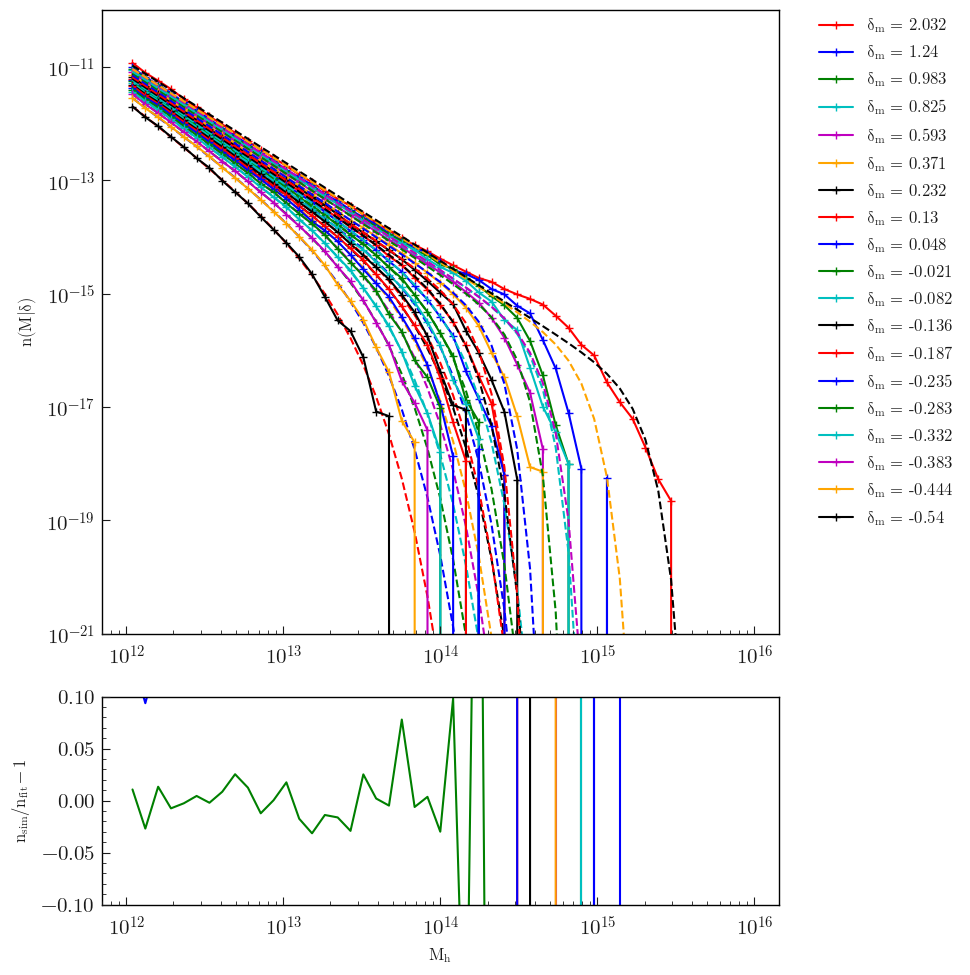

In [115]:
fig, (ax, ax_err) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [3, 1]},figsize = (10, 10))
for i in range(len(delta_mean_list)):
    
    index = len(delta_mean_list) - i -1
    # if index != 0 and index != 5 and index != 15 and index != 18:
    #     continue
    log10_ns, alpha, log10_M0,  beta  = parameters[i]

    ax.loglog(mass_bin_centre, nM_list[index], color = color_list[i], marker = "+", label = rf'$\delta_m$ = {np.round(delta_mean_list[index], 3)}')
    nM_schechter= schechter_function(M = mass_bin_centre, log10_M0=log10_M0 , log10_ns=log10_ns, alpha=alpha, beta=beta)
    # ax.loglog(mass_bin_centre, term1, color='b')
    # ax.loglog(mass_bin_centre, term2, '-.', color='b')
    ax.loglog(mass_bin_centre, nM_schechter, '--', color = color_list[i] )
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    # nM_schechter_lower = schechter_function(mass_bin_centre, *parameters_lower[i], with_terms=False)
    # nM_schechter_higher = schechter_function(mass_bin_centre, *parameters_higher[i], with_terms=False)
    # ax.fill_between(mass_bin_centre, nM_schechter_lower, nM_schechter_higher, color = color_list[i], alpha = 0.2)
    ax.set_ylim(1e-21, 1e-10)
    ax_err.plot(mass_bin_centre, (nM_list[index]/nM_schechter) -1, color = color_list[i])
    ax_err.set_xscale('log')
    ax_err.set_ylim(-0.1, 0.1)
    ax.set_ylabel(r'$n(M|\delta)$',fontsize = 12)
    ax_err.set_xlabel(r'$M_h$', fontsize = 12)
    ax_err.set_ylabel(r'$n_{sim}/n_{fit} - 1$', fontsize = 12)
# ax.set_xlim(1e12, 1e14)
plt.tight_layout()
fig.savefig(f'{figs_dir}/sch_12_16.png', dpi = 300)

In [ ]:
parameters = np.array(parameters)
parameters = np.flip(parameters, axis = 0)
parameters_errors = np.array(parameters_errors)
parameters_errors = np.flip(parameters_errors, axis = 0)

(19, 4)

In [ ]:
np.save(rf'{data_dir}/parameters_diff_evol_12_16.npy', np.array(parameters))
np.save(rf'{data_dir}/parameters_diff_evol_12_16.npy', np.array(parameters_errors))

In [63]:
w = np.ones_like(log_delta)
w[-4:] = 0.25

In [150]:
from scipy.interpolate import UnivariateSpline

log10ns_interp = UnivariateSpline(y =parameters[:, 0], x = log_delta, k = 1, s = 2, ext = 0, w = w)


log10M0_interp = UnivariateSpline(y =parameters[:, 2], x = log_delta, k = 1, s = 1, ext = 0, w = w)


alpha_interp = UnivariateSpline(y = parameters[:, 1], x = log_delta, k = 1, s = 1, ext = 0, w = w)



beta_interp = UnivariateSpline(y =parameters[:, 3], x = log_delta, k = 1, s = 1, ext = 0, w = w)



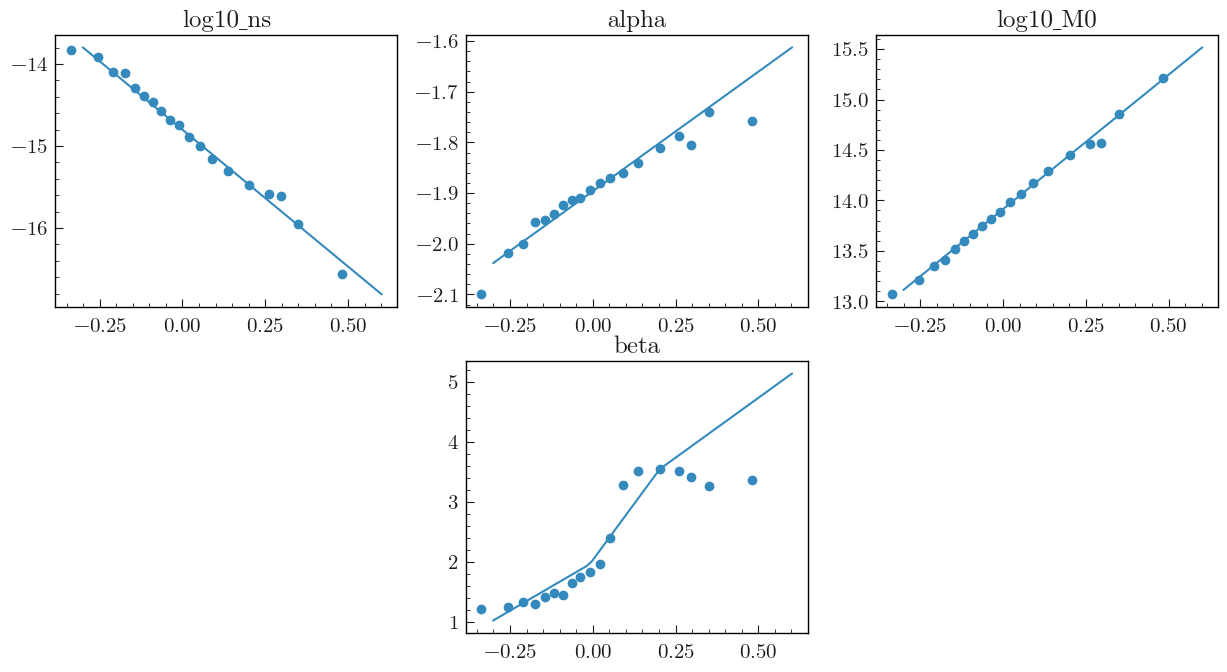

In [151]:
x = np.linspace(-1, 5)

log_delta = np.log10(1 + np.array(delta_mean_list))


fig = plt.figure(figsize=(15, 12))

# Top row - 3 panels
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1))
ax3 = plt.subplot2grid((3, 3), (0, 2))

# Middle row - 1 panel spanning all 3 columns
ax4 = plt.subplot2grid((3, 3), (1, 1), colspan=1)











ax1.set_title('log10_ns')
ax1.scatter(log_delta, parameters[:, 0])
ax1.plot(log_delta_m, log10ns_interp(log_delta_m))

ax2.set_title('alpha')
ax2.scatter(log_delta, parameters[:, 1])
ax2.plot(log_delta_m, alpha_interp(log_delta_m))



ax3.set_title('log10_M0')
ax3.scatter(log_delta, parameters[:, 2])
ax3.plot(log_delta_m,log10M0_interp(log_delta_m))


ax4.set_title('beta')
ax4.scatter(log_delta, parameters[:, 3])
ax4.plot(log_delta_m, beta_interp(log_delta_m))





In [152]:
M_min = 10**12
M_max = 10**15


M_halo_bin_edges = np.logspace(np.log10(M_min), np.log10(M_max), 6)

In [153]:
nh_list = []
delta_m = np.log10(1 + np.linspace(-0.9, 2.5, 100))
log_M_bin_edges = np.log10(M_halo_bin_edges)

In [154]:
def nh(log10_one_delta_m, log10_Mmin, log10_Mmax, *funcs):
    log10_ns_func, alpha_func, log10_M0_func, beta_func = funcs
    
    log10_ns = log10_ns_func(log10_one_delta_m)
    alpha = alpha_func(log10_one_delta_m)
    log10_M0 = log10_M0_func(log10_one_delta_m)
    beta = beta_func(log10_one_delta_m)
    
    log10_min = log10_Mmin - log10_M0
    log10_max = log10_Mmax - log10_M0
    
    Gamma_min = gammainc_vec((alpha + 1)/beta, (10**log10_min)**beta)
    Gamma_max = gammainc_vec((alpha + 1)/beta, (10**log10_max)**beta)
    term1 = (10**log10_ns)*(10**log10_M0)*(1/beta)* (Gamma_min - Gamma_max)
    
    
    
   
    return term1

In [155]:
term1_list = []
term2_list = []

for i in range(log_M_bin_edges.size - 1): 
    value = nh(log_delta_m, log_M_bin_edges[i], log_M_bin_edges[i + 1], log10ns_interp, alpha_interp, log10M0_interp, beta_interp)
    nh_list.append(value)
    


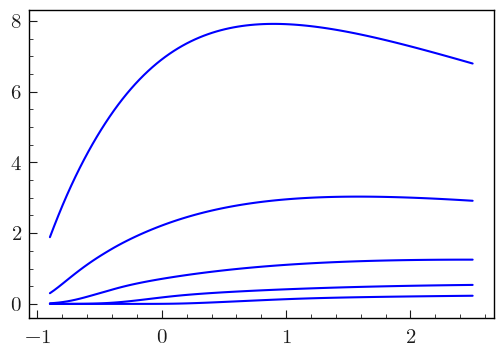

In [156]:
for i in range(log_M_bin_edges.size - 1):
    plt.plot(np.linspace(-0.9, 2.5, 100), nh_list[i], color = 'b')
    # plt.plot(np.linspace(-0.9, 2.5, 100), term1_list[i], color= 'r', ls = '--')
    # plt.plot(np.linspace(-0.9, 2.5, 100), term2_list[i], color='g')
# plt.yscale("log")


In [103]:
np.save("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list_lower.npy", nh_list)